# The Model Development

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES=True

## Looking at the data

# of cat imgs training: 4000
# of dog imgs training: 4000
# of cat imgs validation: 1000
# of dog imgs validation: 1000
Sample Images


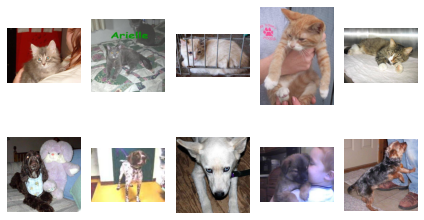

In [2]:
import os
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

train_lst_of_cat_imgs = np.array(os.listdir("train\\cats"))
train_lst_of_dog_imgs = np.array(os.listdir("train\\dogs"))

val_lst_of_cat_imgs = np.array(os.listdir("val\\cats"))
val_lst_of_dog_imgs = np.array(os.listdir("val\\dogs"))

print(f"# of cat imgs training: {len(train_lst_of_cat_imgs)}")
print(f"# of dog imgs training: {len(train_lst_of_dog_imgs)}")

print(f"# of cat imgs validation: {len(val_lst_of_cat_imgs)}")
print(f"# of dog imgs validation: {len(val_lst_of_dog_imgs)}")

five_random_cat_imgs = np.random.choice(train_lst_of_cat_imgs, size=5, replace=False)
five_random_dog_imgs = np.random.choice(train_lst_of_dog_imgs, size=5, replace=False)

fig, ax = plt.subplots(nrows=2, ncols=5)

for i in range(5):
    ax[0,i].imshow(Image.open(f"train\\cats\\{five_random_cat_imgs[i]}"))
    ax[0,i].axis("off")
    ax[1,i].imshow(Image.open(f"train\\dogs\\{five_random_dog_imgs[i]}"))
    ax[1,i].axis("off")

print("Sample Images")
plt.tight_layout()
plt.show()

## Setting Up Datasets and Dataloaders

Calculate the mean and st. dev. for each of the dimensions.



In [3]:
cat_imgs = []
dog_imgs = []

for img in train_lst_of_cat_imgs:
    cat_imgs.append(np.array(Image.open(f"train\\cats\\{img}")))

for img in train_lst_of_dog_imgs:
    dog_imgs.append(np.array(Image.open(f"train\\dogs\\{img}")))

all_imgs = cat_imgs + dog_imgs

# for image in lst_of_all_imgs:


In [11]:
mean_imgs = np.zeros(shape=(len(all_imgs), 3))
std_imgs = np.zeros(shape=(len(all_imgs), 3))

for i in range(len(all_imgs)):
    mean_imgs[i] = np.mean(all_imgs[i], axis=(0,1))
    std_imgs[i] = np.std(all_imgs[i], axis=(0,1))

115.6725960553722
57.76951084886384


In [14]:
print(np.mean(mean_imgs, axis=0)/255)
print(np.mean(std_imgs, axis=0)/255)

[0.48829682 0.45512981 0.41742744]
[0.22969397 0.22472397 0.22522336]


We define the transforms for each image

In [50]:
img_transforms = transforms.Compose([
    transforms.Resize((64, 64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])

In [51]:
train_data_path = "train"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms)

In [52]:
val_data_path = "val"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms)

In [53]:
batch_size=64
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 64, 64])
Labels batch shape: torch.Size([64])
<class 'torch.Tensor'>
torch.Size([3, 64, 64])


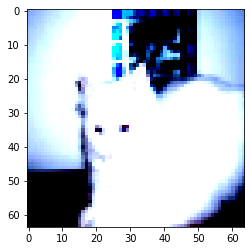

Label: 0


In [54]:
train_features, train_labels = next(iter(train_data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(type(img))
print(img.shape)

plt.imshow(np.array(img).transpose(1,2,0))
plt.show()
print(f"Label: {label}")

## Training

In [55]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [59]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input, target = batch
            output = model(input)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.data.item()
        training_loss /= len(train_loader)
    
        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            input, target = batch
            output = model(input)
            loss = loss_fn(output,target)

            valid_loss += loss.data.item()
            correct = torch.eq(torch.max(F.softmax(output, dim=-1), dim=1)[1], target).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader)
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch+1, training_loss, valid_loss, num_correct / num_examples))


### Define Model

First we create a simply fully connected neural network

In [60]:
import torch.nn as nn
import torch.nn.functional as F

class Simplenn(nn.Module):

    def __init__(self) -> None:
        super(Simplenn, self).__init__()

        self.fc1 = nn.Linear(12288, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = x.view(-1, 12288)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Second model to try is a CNN

In [41]:
class SimpleCNN(nn.Module):

    def __init__(self, num_classes=2) -> None:
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),            

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Import pretrained ResNet

In [66]:
from torchvision import models
transfer_model = models.resnet50(pretrained=True)

print(transfer_model)

for name, param in transfer_model.named_parameters():
    param.requires_grad = False


transfer_model.fc = nn.Sequential(
    nn.Linear(transfer_model.fc.in_features, 2))

print(transfer_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Train Model

Training the simple fully connected neural net.

In [61]:
simple_model = Simplenn()
# simple_model.to(device)
optimizer = optim.Adam(simple_model.parameters(), lr=0.001)

train(simple_model, optimizer, torch.nn.CrossEntropyLoss(), 
        train_data_loader, val_data_loader, epochs=10, device=device)


Epoch: 1, Training Loss: 0.72, Validation Loss: 0.68, accuracy = 0.59
Epoch: 2, Training Loss: 0.63, Validation Loss: 0.67, accuracy = 0.60
Epoch: 3, Training Loss: 0.59, Validation Loss: 0.68, accuracy = 0.61
Epoch: 4, Training Loss: 0.56, Validation Loss: 0.65, accuracy = 0.63
Epoch: 5, Training Loss: 0.51, Validation Loss: 0.69, accuracy = 0.63
Epoch: 6, Training Loss: 0.47, Validation Loss: 0.76, accuracy = 0.61
Epoch: 7, Training Loss: 0.43, Validation Loss: 0.79, accuracy = 0.61
Epoch: 8, Training Loss: 0.38, Validation Loss: 0.92, accuracy = 0.62
Epoch: 9, Training Loss: 0.36, Validation Loss: 0.88, accuracy = 0.64
Epoch: 10, Training Loss: 0.31, Validation Loss: 0.97, accuracy = 0.63


Saving the model params

In [62]:
torch.save(simple_model.state_dict(), "tmp\\simple_model")

Training the CNN (AlexNet)

In [63]:
cnn_model = SimpleCNN()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

train(cnn_model, optimizer, torch.nn.CrossEntropyLoss(), 
        train_data_loader, val_data_loader, epochs=10, device=device)

Epoch: 1, Training Loss: 0.77, Validation Loss: 0.69, accuracy = 0.50
Epoch: 2, Training Loss: 0.69, Validation Loss: 0.69, accuracy = 0.50
Epoch: 3, Training Loss: 0.69, Validation Loss: 0.69, accuracy = 0.50


KeyboardInterrupt: 

Saving the model params

In [23]:
torch.save(cnn_model.state_dict(), "tmp\\cnn_model")

Training the pretrained resnet

In [67]:
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

train(transfer_model, optimizer, torch.nn.CrossEntropyLoss(), 
        train_data_loader, val_data_loader, epochs=10, device=device)


Epoch: 1, Training Loss: 0.50, Validation Loss: 0.46, accuracy = 0.79
Epoch: 2, Training Loss: 0.45, Validation Loss: 0.52, accuracy = 0.75
Epoch: 3, Training Loss: 0.43, Validation Loss: 0.44, accuracy = 0.80
Epoch: 4, Training Loss: 0.43, Validation Loss: 0.46, accuracy = 0.78
Epoch: 5, Training Loss: 0.42, Validation Loss: 0.47, accuracy = 0.78
Epoch: 6, Training Loss: 0.43, Validation Loss: 0.43, accuracy = 0.80
Epoch: 7, Training Loss: 0.40, Validation Loss: 0.46, accuracy = 0.80
Epoch: 8, Training Loss: 0.41, Validation Loss: 0.43, accuracy = 0.80
Epoch: 9, Training Loss: 0.42, Validation Loss: 0.44, accuracy = 0.80
Epoch: 10, Training Loss: 0.39, Validation Loss: 0.44, accuracy = 0.79


## Testing

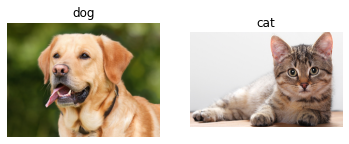

In [73]:
labels = ["cat", "dog"]

img1 = Image.open("single_prediction\\cat_or_dog_1.jpg")
img2 = Image.open("single_prediction\\cat_or_dog_2.jpg")

prediction1 = transfer_model(img_transforms(img1).unsqueeze(0))
prediction1 = torch.max(F.softmax(prediction1, dim=-1), dim=1)[1]

prediction2 = transfer_model(img_transforms(img2).unsqueeze(0))
prediction2 = torch.max(F.softmax(prediction2, dim=-1), dim=1)[1]

fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(img1)
ax[0].set_title(labels[prediction1])
ax[0].axis("off")

ax[1].imshow(img2)
ax[1].set_title(labels[prediction2])
ax[1].axis("off")

plt.show()